#EECS 504 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

 Elsa Mary Mathew, elmathew

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"


PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Contruct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [0]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab. 
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2020-02-17 01:14:43--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.199
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  5.39MB/s    in 1m 41s  

2020-02-17 01:16:25 (5.07 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [0]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient. 
!unzip -q data_miniplaces_modified.zip

## Step 1: Build dataloaders for train, val, and test

In [0]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    '''
    Build dataloaders with transformations. 

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.

    '''

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #  

    # ========= Step 1: build transformations for the dataset ===========
    # You need to construct build a data transformation that does three preprocessings in order:
    # I. Resize the image to input_size using transforms.Resize
    # II. Convert the image to PyTorch tensor using transforms.ToTensor
    # III. Normalize the images with the provided mean and std parameters using transforms.Normalize. These parameters are accumulated from a large number of training samples.
    # You can use transforms.Compose to combine the above three transformations. 
    Transform_list=transforms.Compose([transforms.Resize(input_size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean,std)])
    # ========= Step 2: build dataloaders for the downloaded data ===========
    # I. use torchvision.datasets.ImageFolder with the provided data_dir and the data transfomations 
    #you created in step 1 to contruct pytorch datasets for train/val/test 
    # II. use torch.utils.data.DataLoader to build dataloaders with the constructed pytorch datasets
    # you need to enable shuffling for training set. Set num_workers=2 to speed up dataloading.
    # III. put the dataloaders into a dictionary
    #Step I.
    data_dir = "./data_miniplaces_modified"
    dataset_train=datasets.ImageFolder("./data_miniplaces_modified/train",transform=Transform_list)
    dataset_test=datasets.ImageFolder("./data_miniplaces_modified/test",transform=Transform_list)
    dataset_val=datasets.ImageFolder("./data_miniplaces_modified/val",transform=Transform_list)
    #Step II.
    dataloader_train=torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True,num_workers=2)
    dataloader_test=torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,num_workers=2)
    dataloader_val=torch.utils.data.DataLoader(dataset_val, batch_size=batch_size,num_workers=2)

    dataloaders_dict={"train":dataloader_train,"test":dataloader_test,"val":dataloader_val}


    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return dataloaders_dict

In [0]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset))) 
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))  
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset))) 

# of training samples 90000
# of validation samples 10000
# of test samples 10000


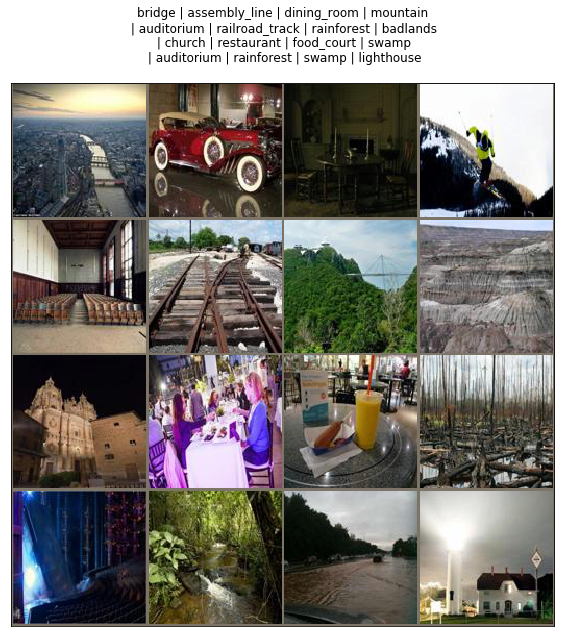

In [0]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## Step 2. Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [0]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    '''

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [0]:
# Network configurations for all layers before the final fully-connected layers. 
# "M" corresponds to maxpooling layer, integers correspond to number of output channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):

    '''
    Return a nn.Sequential object containing all layers before the fully-connected layers in the VGG11 network. 

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction layers. For use of torch.nn.Sequential,
       please refer to PyTorch documents.
    '''
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    layers=[]
    prev=3
    for idx,i in enumerate(cfg):
      if idx==0:
        layers.append(torch.nn.Conv2d(3,i, kernel_size=(3, 3),stride=(1,1),padding=(1,1)))
        prev=i
        if batch_norm==True:
              layers.append(torch.nn.BatchNorm2d(i,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True))
        
        layers.append(torch.nn.ReLU(inplace=True))

      elif i=='M':
        layers.append(torch.nn.MaxPool2d(kernel_size=2,stride=2,padding=0,dilation=1,ceil_mode=False))

      else:
        layers.append(torch.nn.Conv2d(prev,i, kernel_size=(3, 3),stride=(1,1),padding=(1,1)))
        prev=i
        if batch_norm==True:
            layers.append(torch.nn.BatchNorm2d(i,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True))
        layers.append(torch.nn.ReLU(inplace=True))


    features = nn.Sequential(*layers)

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        # Construct the final FC layers using nn.Sequential. 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        self.classifier = nn.Sequential(torch.nn.Linear(in_features=3200, out_features=512,bias=True), 
                                        torch.nn.ReLU(inplace=True),
                                        torch.nn.Dropout(p=0.3,inplace=False),
                                        torch.nn.Linear(in_features=512, out_features=256,bias=True), 
                                        torch.nn.ReLU(inplace=True),
                                        torch.nn.Dropout(p=0.3,inplace=False),
                                        torch.nn.Linear(in_features=256, out_features=100,bias=True))
        

        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        if init_weights:
            self._initialize_weights()

    def forward(self, x): 
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [0]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with the one given in the instruction above. 
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## Step 3: Build training/validation loops

You will write a function for training and validating the network. 

In [0]:
def make_optimizer(model):
    '''
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    '''
    # Create an Adam optimizer with a learning rate 1e-3
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return optimizer

def get_loss():
    '''
    Returns:
        criterion: pytorch loss. 
    '''

    # Create an instance of the cross entropy loss function
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # The code should be a one-liner.
    criterion=nn.CrossEntropyLoss()
    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

    return criterion

In [0]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    '''
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    '''

    val_acc_history = []
    tr_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 
                # ============== YOUR CODE HERE ============== #
                # For "train" phase, compute the outputs, calculate the loss, update the model parameters
                # For "val" phase, compute the outputs, calculate the loss
                #with torch.set_grad_enabled(phase=="train"):
                if phase=="train":
                  outputs=model(inputs)
                  _,preds=torch.max(outputs,1)
                  #oss = loss_fn(max_out, y)
                  loss=criterion(outputs,labels)

                  optimizer.zero_grad()

                  loss.backward()

                  # Calling the step function on an Optimizer makes an update to its parameters
                  optimizer.step()
                
                if phase=="val":
                  outputs=model(inputs)
                  _,preds=torch.max(outputs,1)
                  loss=criterion(outputs,labels)


                # ============== END OF CODE ================= # 
                #++++++++++++++++++++++++++++++++++++++++++++++#
                #++++++++++++++++++++++++++++++++++++++++++++++# 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # ================================ IMPORTANT ===============================================
                # Lossing connection to colab will lead to loss of trained weights.
                # You can download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to train the neural networks again.
                # ==========================================================================================
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## Step 4. Train MiniVGG and MiniVGG-BN

In [0]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training 
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloders and criterion function
input_size = 64 # do not change this
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [0]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 4.0787 Acc: 0.0623


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.6840 Acc: 0.1250
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.5210 Acc: 0.1489


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.3019 Acc: 0.1861
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2593 Acc: 0.1940


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.2047 Acc: 0.2024
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0887 Acc: 0.2260


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0484 Acc: 0.2396
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9512 Acc: 0.2538


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9370 Acc: 0.2637
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8267 Acc: 0.2778


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8834 Acc: 0.2767
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7166 Acc: 0.3009


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8424 Acc: 0.2792
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6104 Acc: 0.3201


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7981 Acc: 0.2969
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5119 Acc: 0.3399


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7685 Acc: 0.3020
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4194 Acc: 0.3564


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8218 Acc: 0.2997
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3263 Acc: 0.3771


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8361 Acc: 0.2972
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2494 Acc: 0.3928


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8923 Acc: 0.2961
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1604 Acc: 0.4092


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9119 Acc: 0.2934
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0849 Acc: 0.4241


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9245 Acc: 0.2932
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.0007 Acc: 0.4428


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9622 Acc: 0.2960
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.9395 Acc: 0.4555


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9790 Acc: 0.2987
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8716 Acc: 0.4713


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0755 Acc: 0.2839
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.8057 Acc: 0.4852


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0724 Acc: 0.2874
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.7475 Acc: 0.4992


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1133 Acc: 0.2845
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 1.6894 Acc: 0.5120


100%|██████████| 79/79 [00:07<00:00, 11.99it/s]

val Loss: 3.1781 Acc: 0.2885
Best val Acc: 0.302000


In [0]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

  0%|          | 0/704 [00:00<?, ?it/s]

Epoch 0/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.9014 Acc: 0.0879


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.5033 Acc: 0.1487
Epoch 1/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.4657 Acc: 0.1564


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.3329 Acc: 0.1866
Epoch 2/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.2859 Acc: 0.1874


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.1436 Acc: 0.2160
Epoch 3/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.1642 Acc: 0.2111


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 3.0738 Acc: 0.2303
Epoch 4/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 3.0628 Acc: 0.2286


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9454 Acc: 0.2552
Epoch 5/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.9755 Acc: 0.2462


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.9365 Acc: 0.2599
Epoch 6/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8946 Acc: 0.2636


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8051 Acc: 0.2888
Epoch 7/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.8188 Acc: 0.2778


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.8585 Acc: 0.2749
Epoch 8/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.7622 Acc: 0.2886


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6883 Acc: 0.3100
Epoch 9/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6871 Acc: 0.3059


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.7284 Acc: 0.3036
Epoch 10/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.6251 Acc: 0.3163


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6530 Acc: 0.3184
Epoch 11/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5646 Acc: 0.3304


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6433 Acc: 0.3238
Epoch 12/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.5084 Acc: 0.3402


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6093 Acc: 0.3305
Epoch 13/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4521 Acc: 0.3519


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6590 Acc: 0.3226
Epoch 14/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.4003 Acc: 0.3622


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6011 Acc: 0.3342
Epoch 15/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.3495 Acc: 0.3727


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5751 Acc: 0.3361
Epoch 16/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2957 Acc: 0.3841


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5464 Acc: 0.3445
Epoch 17/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2466 Acc: 0.3935


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.5451 Acc: 0.3473
Epoch 18/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.2044 Acc: 0.4026


  0%|          | 0/704 [00:00<?, ?it/s]

val Loss: 2.6144 Acc: 0.3377
Epoch 19/19
----------


  0%|          | 0/79 [00:00<?, ?it/s]

train Loss: 2.1476 Acc: 0.4141


100%|██████████| 79/79 [00:08<00:00,  9.69it/s]

val Loss: 2.5506 Acc: 0.3555
Best val Acc: 0.355500


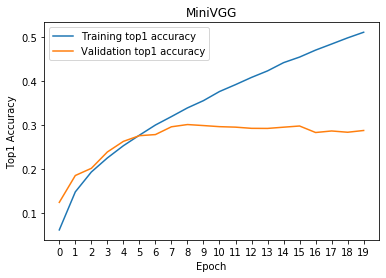

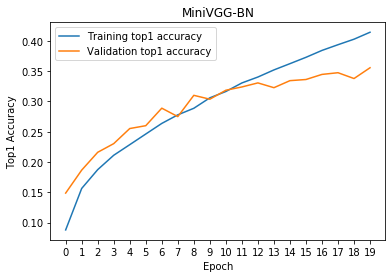

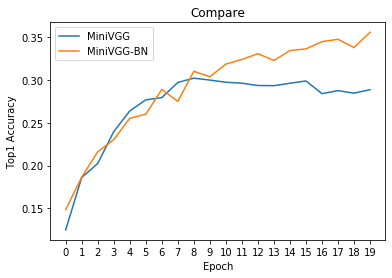

In [0]:
# visualize the training / validation accuracies

x = np.arange(num_epochs)

# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, tr_his)
plt.plot(x, val_his)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, tr_his_BN)
plt.plot(x, val_his_BN)
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, val_his)
plt.plot(x, val_his_BN)
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

###__Summarize the effect of batch normalization:__

Please write a few sentences here to summarize the effect of batch nomalization.

Unnormalised data can lead to badly conditoned curvatures,Batch normalization normalizes the activations of each layer of a network to have zero mean and unit variance. 

Batch normalization is a recently popularized method for accelerating the training of deep feed-forward neural networks. Apart from speed improvements, the technique enables the use of higher learning rates, less careful parameter initialization, and saturating nonlinearities.

Overall, batch normalized models achieve higher validation and test accuracies on all datasets, due to it's regularizing effect and more stable gradient propagation.


## Step 5. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [0]:
def accuracy(output, target, topk=(1,)):
    '''
    Computes the accuracy over the k top predictions for the specified values of k.
    
    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.
    
    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    '''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [0]:
##### To pass the test, both networks should have Top-5 accuracy above 50% #####
# uncomment these two lines to load pretrained weights
# vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
# vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 34.66%, Top-5 accuracy 65.36%
Top-1 accuracy 28.42%, Top-5 accuracy 56.59%
